### MACHINE LEARNING FOR FINANCIAL MARKETS

TOPIC: IMPROVING TIME SERIES FORECASTING WITH SYNTHETIC DATA

Tools used: LSTM Neural Networks and TimeGAN (specifically introduced for Time Series)

In [468]:
#Import all the necessary libraries for LSTM and GANs

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam #adam is the optimizer we are going to use
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout

# STEP 0: Explore the dataset

In [469]:
#load the dataset (data from 02/20/2015 to 02/19/2025)
path = '/Users/francescavasta/Desktop/ADSEM/II YEAR I SEM/ML for financial markets/MSFT historical data.csv'
df = pd.read_csv(path)

df = df[['Date', 'Close/Last']]
df.info()

#we see that we have a problem with the date format because it is a string
#also the stock value is a string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2515 non-null   object
 1   Close/Last  2515 non-null   object
dtypes: object(2)
memory usage: 39.4+ KB


In [470]:
#handling of ['Date'] values
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month, day, year = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month = month, day=day)

#testing the function
#datetime_object = str_to_datetime('02/20/2015')
#datetime_object

df['Date'] = df['Date'].apply(str_to_datetime)
df

,Date,Close/Last
0,2025-02-19,$414.77
1,2025-02-18,$409.64
2,2025-02-14,$408.43
3,2025-02-13,$410.54
4,2025-02-12,$409.04
...,...,...
2510,2015-02-26,$44.055
2511,2015-02-25,$43.99
2512,2015-02-24,$44.09
2513,2015-02-23,$44.15


In [471]:
#handling of Close/Last values
df["Close/Last"] = df["Close/Last"].str.replace(r"\$", "", regex=True) # to remove $
df["Close/Last"] = pd.to_numeric(df["Close/Last"], errors="coerce")
df['Close/Last'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        2515 non-null   datetime64[ns]
 1   Close/Last  2515 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.4 KB


In [472]:
#we prefer to have our data ordered chronologically from past to future 
df = df.sort_values(by="Date", ascending=True)
df = df.reset_index(drop=True)
df

,Date,Close/Last
0,2015-02-20,43.855
1,2015-02-23,44.150
2,2015-02-24,44.090
3,2015-02-25,43.990
4,2015-02-26,44.055
...,...,...
2510,2025-02-12,409.040
2511,2025-02-13,410.540
2512,2025-02-14,408.430
2513,2025-02-18,409.640


In [473]:
#RUN THIS CODE and change DF to DF_FILTERED in case you want to reduce the lenght of the time period considered
df['Date'] = pd.to_datetime(df['Date'])  # Ensure the 'Date' column is datetime
df_filtered = df[df['Date'] >= '2022-01-01']

In [474]:
#now we want to remove the index and make the date itslef as the index
df_filtered.index = df_filtered.pop('Date')
df_filtered

,Close/Last
Date,
2022-01-03,334.75
2022-01-04,329.01
2022-01-05,316.38
2022-01-06,313.88
2022-01-07,314.04
...,...
2025-02-12,409.04
2025-02-13,410.54
2025-02-14,408.43


# PART 1: the main assumption of ARIMA models is the STATIONARITY of the time series

## METHOD 1 to check for stationarity: time series plot
by looking at the plot we can understand if the time serie is stationary or not. 

In our case, from the plot obtained it is clear that the time serie has got an upward trend

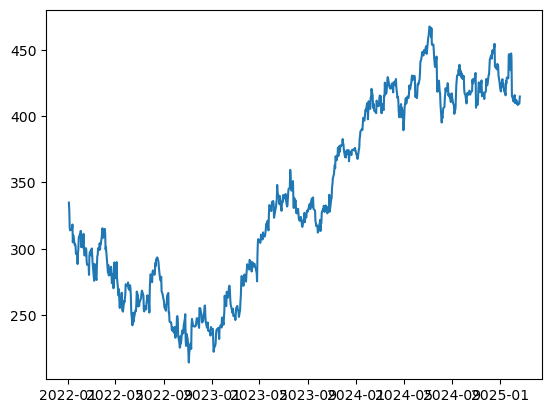

In [475]:
plt.plot(df_filtered)

In [476]:
#df = np.log(df) #we noticed that the time series has got a lot of variance, so we use log-transformation to try to reduce the variance
#df.plot()

In [477]:
# Now we split the data and we also visualize the different sets on the graph
#with time series we can't do random splittings because the cronological order is important, so we use the quantiles

q_90 = int(len(df_filtered)*.9)

df_train = df_filtered.iloc[:q_90].copy() #to select the first 90% observations
df_test = df_filtered.iloc[q_90:].copy() #to select the last 10% observations

## METHOD 2 to check for stationarity: ACF plot and PACF plot
- ACF (autocorrelation function) is the correlation of the time series with its lags
- PACF (partial autocorrelation function) is the partial correlation of the time series with its lags, after removing the effects of lower-order-lags between them

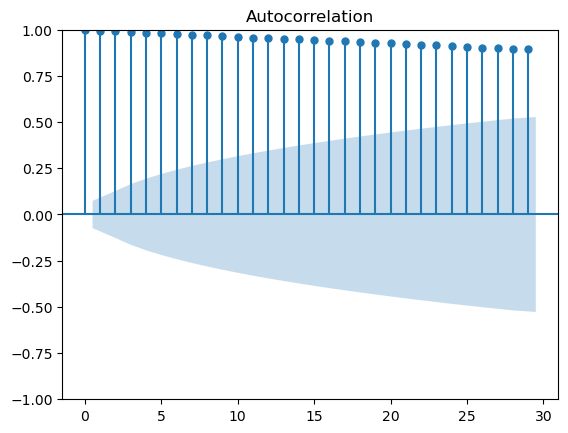

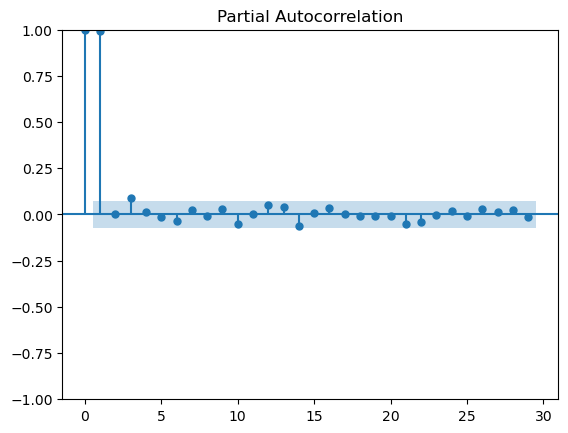

In [478]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(df_train)
pacf_original = plot_pacf(df_train)

**COMMENT**
First graph (ACF): we notice that the autocorrelation values are very high (close to 1.0) and persist even for higher lags.
The values decrease very slowly as the lag increases. There are no signs of a rapid decline toward zero.

Second graph (PACF): There is a significant peak at lag 1.
After lag 1, the values quickly approach zero. The values oscillate around zero with minimal significance.

The time series shows strong indications of **non-stationarity.**, indeed the ACF pattern, with high and persistent correlations, is typical of non-stationary series. This suggests the presence of a trend or an integrated component in the series.

Next steps? To make the series stationary, we would need to:
- Applying a first-order differencing.
- Re-examining the ACF and PACF plots of the differenced series.
- Determining the appropriate p and q values for an ARIMA(p,d,q) model


# METHOD 3: ADF test
the ADF test is a test to check stationarity. The null hypothesis is that there is a unit root (non-stationarity). If the p-value is high, then we reject the null hypothesis. 

In [479]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value:{adf_test[1]}')

p-value:0.9130172967504677


# From non-stationary to stationary: DIFFERENCING (first order)

Differencing is a technique used to make a non-stationary time series stationary. It involves calculating the difference between consecutive observations in the series. In other words, Each value in the series is replaced by the difference between itself and the previous value.
This operation removes linear trends and reduces autocorrelation, eliminating the integrated component of the series.
If the series remains non-stationary after first-order differencing, a second-order differencing can be applied (i.e., taking the difference of the differences).

The order of the differencing will determine the value of parameter "d" in our ARIMA model.
If the time serie is stationary (Without differencing) then d = 0, otherwise 1 or 2 if the differencing was of first-order or second-order

<Axes: xlabel='Date'>

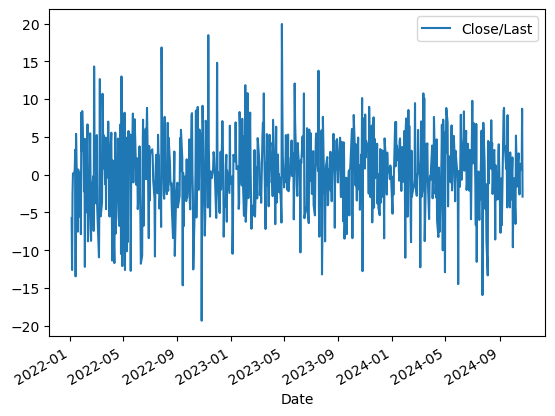

In [480]:
df_train_diff = df_train.diff().dropna()
df_train_diff.plot()

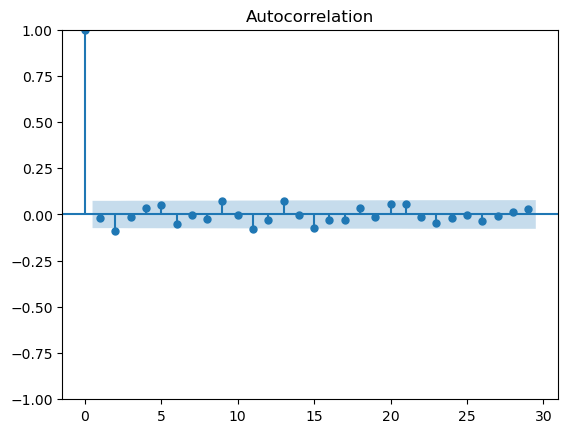

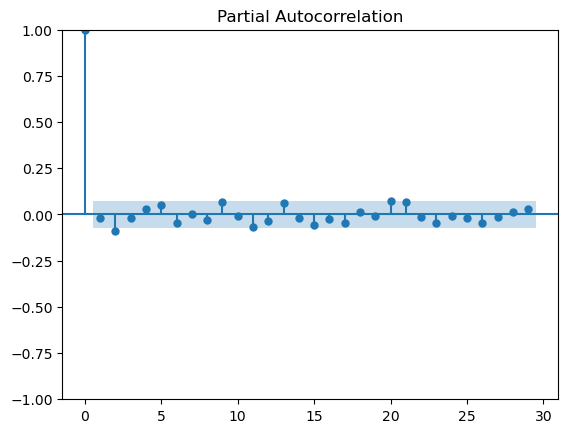

In [481]:
acf_diff = plot_acf(df_train_diff)
pacf_diff = plot_pacf(df_train_diff)

compared to the previous PACF and ACF graph, now that we have performed differencing, the values are not so highly correlated with the previous lags anymore

In [482]:
adf_test = adfuller(df_train_diff)
print(f'p-value:{adf_test[1]}')

p-value:0.0


the p-value now dropped. We have successfully transformed our time serie from non-stationary to stationary ! 

# STEP 2: Determine ARIMA models parameters p,d and q 
ARIMA (p,d,q)
- p (AutoRegressive - AR term): The number of lagged values (past observations) used to predict the current value. (f p = 1, the model uses one lagged value)
- d = number of times differencing is applied to achieve stationarity.
- q (Moving Average - MA term): The number of past forecast errors included in the model. (If q = 1, the model includes one past error term:)

We have applied a first order differencing so the parameter d is set to 1 -> ARIMA (p,1,q)

How to select the values of p and q? by **looking at the ACF and PACF plots** 
- We choose p by looking at the partial autocorrelation plot

Rule of thumb:
The PACF measures the balance-variance of the lags and helps us understand whethter we should include or not a lag in the model.
The ACF measures the correlation with the lags and helps us understand the moving average of the model.
If the PAC plot has a significant spike at lag p, but not beyond; the ACF plot decays more gradually. This may suggest an ARIMA(p, d, 0) model.
If the ACF plot has a significant spike at lag q, but not beyond; the PAC plot decays more gradually.
This may suggest an ARIMA(0, d, q) model.


If we look at the ACF, there is still significant peak at lag 2 (which is always 1 by definition). After lag 0, all values oscillate around zero and remain within the confidence bands (the light blue area). There are no evident patterns or autocorrelation structures

If we look at the new PACF, there is still one significant peak at lag 2.
At lag 1, there is a slightly significant negative value. All other values are essentially within the confidence bands

For the p (AR) parameter: Since the PACF shows a possibly significant value at lag 2, we could consider p = 2.
For the q (MA) parameter: The ACF show significant values at lag 2, q = 2 might be appropriate.

We should use an **ARIMA(2,1,2)** which means that the series is modeled as a **first-order autoregressive** process after differencing.

# STEP 3: Fit the ARIMA model (2,1,1)

In [483]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order =(2,1,2))
model_fit = model.fit()
print(model_fit.summary())


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Close/Last   No. Observations:                  706
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2168.716
Date:                Sat, 01 Mar 2025   AIC                           4347.433
Time:                        16:47:52   BIC                           4370.223
Sample:                             0   HQIC                          4356.240
                                - 706                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2329      0.085      2.746      0.006       0.067       0.399
ar.L2         -0.8817      0.080    -11.030      0.000      -1.038      -0.725
ma.L1         -0.2288      0.100     -2.284      0.0

# STEP 4: Make time series predictions

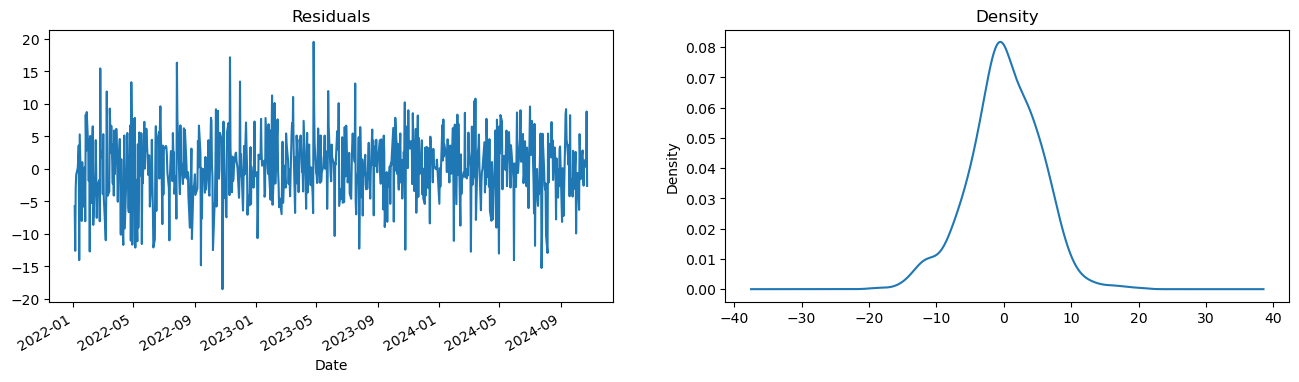

In [484]:
#To check if the model fits good the training set, we can plot the residuals and also the ACF and PACF of the residuals

import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig,ax = plt.subplots(1,2, figsize = (16,4))
residuals.plot(title = 'Residuals', ax = ax [0])
residuals.plot(title = 'Density', kind = 'kde', ax = ax[1])
plt.show()

#The residuals look randomly distributed, the density is normal with mean 0
#All in all, the model fits good.

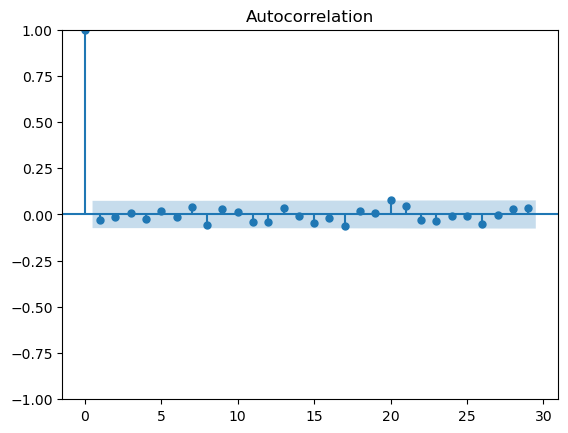

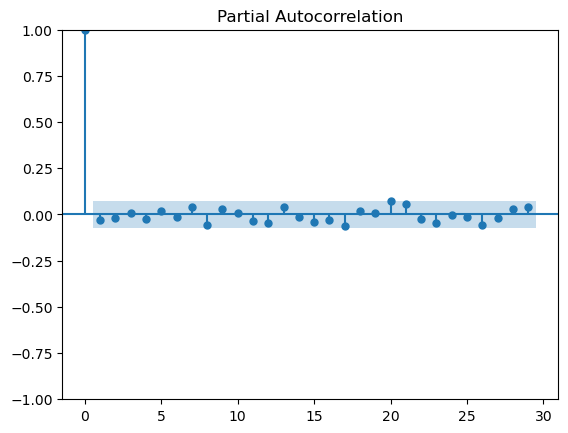

In [485]:
acf_res = plot_acf(residuals)
pacf_res = plot_pacf(residuals)

#The PACF and ACF don't show any relevant spikes (except the first lag)

# Making predictions
Since the model is fitting the training data properly, we can try to make predictions on the test data

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/ls/mj9skg6x7j38ls1ncwhc9s400000gn/T/ipykernel_71428/1580465038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['forecast_ARIMA'] = [None]*len(df_train) + list(forecast_test)


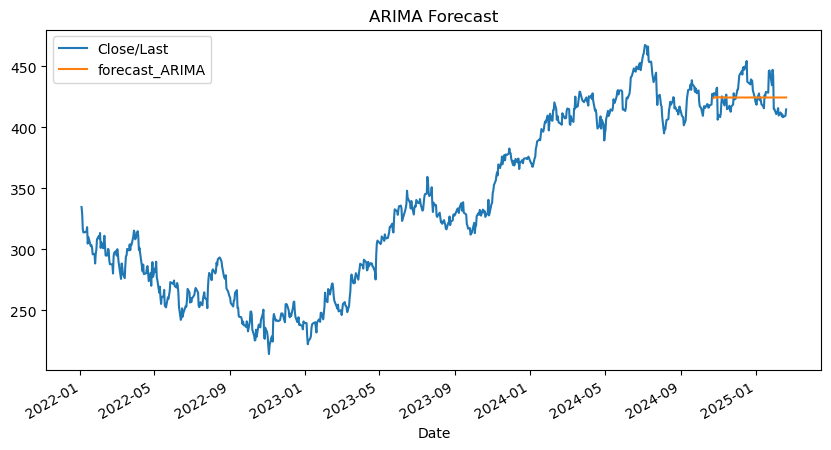

In [ ]:
forecast_test = model_fit.forecast(len(df_test))


df_filtered['forecast_ARIMA'] = [None]*len(df_train) + list(forecast_test)

df_filtered.plot(figsize=(10, 5), title="ARIMA Forecast")

plt.show()

The ARIMA forecast appears as a flat line that maintains the last observed value. Interestingly, despite the model being an ARIMA(1,1,0), the forecast looks very similar to that of a random walk (ARIMA(0,1,0)), which essentially predicts that the future value will be equal to the last observed value.

The lack of fluctuations in the forecast suggests that the AR and MA components (p and q) have minimal effects. The estimated AR(1) coefficient is very small, meaning it has a limited impact on the prediction.

## AUTOMATIC MODELS
one of the most difficult things is to select the right parameters of the ARIMA model

In Python there are some packages that can automatically find the optimal parameters.


In [486]:
#!pip install pmdarima
import pmdarima as pm 
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal = True)
auto_arima

#this automatic process uses AIC to select p and q

ARIMA(order=(2, 1, 2), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

As we can see, the suggestion is to use a SARIMA with 7 parameters

**SARIMA** stands for Seasonal ARIMA:It is an extension of ARIMA that adds a seasonal component. It captures patterns that repeat at regular intervals (weekly, monthly, quarterly, yearly)
It has seven parameters: p, d, q as ARIMA plus P, D, Q (the seasonal equivalents) and m (the length of seasonality)

Basically, if your data show repeating patterns (such as seasonal spikes ), SARIMA is more appropriate. If there are no obvious cyclical patterns, ARIMA is sufficient and simpler.

In [487]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  706
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2168.490
Date:                Sat, 01 Mar 2025   AIC                           4348.981
Time:                        16:48:41   BIC                           4376.330
Sample:                             0   HQIC                          4359.549
                                - 706                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2102      0.319      0.659      0.510      -0.415       0.836
ar.L1          0.2358      0.087      2.704      0.007       0.065       0.407
ar.L2         -0.8785      0.082    -10.706      0.000      -1.039      -0.718
ma.L1         -0.2325      0.103     -2.262      0.024      -0.434      -0.031
ma.L2          0.8167      0.099      8.282      0.000       0.623       1.010
sigma2        27.4874      1.338     20.538      0.000      24.864      30.110
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                10.80
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# STEP 5: Evaluate model predictions

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/ls/mj9skg6x7j38ls1ncwhc9s400000gn/T/ipykernel_71428/138808316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['forecast_ARIMA_auto']= [None]*len(df_train)+list(forecast_test_auto)


<Axes: xlabel='Date'>

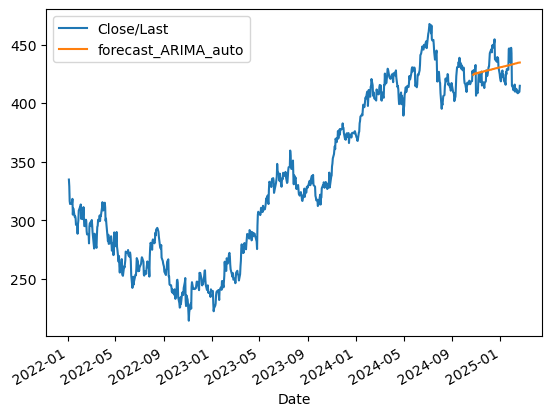

In [493]:
forecast_test_auto = auto_arima.predict(n_periods = len(df_test))
df_filtered['forecast_ARIMA_auto']= [None]*len(df_train)+list(forecast_test_auto)

df_filtered.plot()

In [490]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error (df_test, forecast_test)
mape = mean_absolute_percentage_error(df_test, forecast_test)
rmse = np.sqrt (mean_squared_error(df_test, forecast_test))

print (f'mae - ARIMA manual: {mae}')
print (f'mape - manual: {mape}') 
print (f'rmse - manual: {rmse}')

mae - ARIMA manual: 10.362230445325714
mape - manual: 0.024123680183389555
rmse - manual: 12.661742063918766


In [491]:
mae = mean_absolute_error(df_test, forecast_test_auto)
mape = mean_absolute_percentage_error (df_test, forecast_test_auto)
rmse = np.sqrt (mean_squared_error (df_test, forecast_test_auto))

print(f'mae - ARIMA auto: {mae}')
print (f'mape - ARIMA auto: {mape}')
print(f'rmse - ARIMA auto: {rmse}')

mae - ARIMA auto: 11.478942754922645
mape - ARIMA auto: 0.02706607323130885
rmse - ARIMA auto: 13.615386622989785


## TIME GAN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.models import Model, Sequential

class TimeGAN:
    def __init__(self, seq_len, feature_dim, hidden_dim=24, batch_size=128):
        self.seq_len = seq_len
        self.feature_dim = feature_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.build_model()

    def build_model(self):
        # Encoder
        self.encoder = Sequential([
            LSTM(self.hidden_dim, return_sequences=True, input_shape=(self.seq_len, self.feature_dim)),
            LSTM(self.hidden_dim, return_sequences=False)
        ])

        # Decoder (Recovery network)
        self.decoder = Sequential([
            Dense(self.hidden_dim, activation='relu'),
            Dense(self.seq_len * self.feature_dim, activation='tanh'),
            tf.keras.layers.Reshape((self.seq_len, self.feature_dim))
        ])

        # Generator
        self.generator = Sequential([
            LSTM(self.hidden_dim * 2, return_sequences=True, input_shape=(self.seq_len, self.feature_dim)),
            Dropout(0.2),
            LSTM(self.hidden_dim * 2, return_sequences=True),
            Dropout(0.2),
            TimeDistributed(Dense(self.hidden_dim, activation='relu')),
            TimeDistributed(Dense(self.feature_dim, activation='tanh'))
        ])

        # Supervisor network
        self.supervisor = Sequential([
            LSTM(self.hidden_dim, return_sequences=True, input_shape=(self.seq_len, self.hidden_dim)),
            LSTM(self.hidden_dim, return_sequences=True)
        ])

        # Discriminator
        self.discriminator = Sequential([
            LSTM(self.hidden_dim * 2, return_sequences=True, input_shape=(self.seq_len, self.feature_dim)),
            LSTM(self.hidden_dim, return_sequences=False),
            Dropout(0.3),
            Dense(self.hidden_dim // 2, activation='relu'),
            Dense(1, activation='sigmoid')
        ])


        # Compile Models
        self.encoder.compile(optimizer='adam', loss='mse')
        self.decoder.compile(optimizer='adam', loss='mse')
        self.generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),loss='mse') 
        self.supervisor.compile(optimizer='adam', loss='mse')
        self.discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1 = 0.5), loss='binary_crossentropy')


        # GAN Model (Generator + Discriminator)
        self.discriminator.trainable = False
        gan_input = tf.keras.Input(shape=(self.seq_len, self.feature_dim))
        generated_samples = self.generator(gan_input)
        gan_output = self.discriminator(generated_samples)
        self.gan = Model(gan_input, gan_output)
        self.gan.compile(optimizer='adam', loss='binary_crossentropy')

    def train(self, data, epochs=1000):
        d_losses, g_losses = [], []

        for epoch in range(epochs):
            idx = np.random.randint(0, data.shape[0], self.batch_size)
            real_samples = data[idx]
            noise = np.random.normal(0, 1, (self.batch_size, self.seq_len, self.feature_dim))
            fake_samples = self.generator.predict(noise)

            # Train Discriminator
            real_labels = np.random.uniform(0.9, 1.0, (self.batch_size, 1))
            fake_labels = np.random.uniform(0.0, 0.1, (self.batch_size, 1))
            d_loss_real = self.discriminator.train_on_batch(real_samples, real_labels)
            d_loss_fake = self.discriminator.train_on_batch(fake_samples, fake_labels)
            d_loss = 0.5 * (d_loss_real + d_loss_fake)

            # Train Generator
            g_loss = self.gan.train_on_batch(noise, np.ones((self.batch_size, 1)))

            d_losses.append(d_loss)
            g_losses.append(g_loss)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}: D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

        # Visualizza il grafico delle loss
        plt.figure(figsize=(10, 6))
        plt.plot(d_losses, label='Discriminator Loss', alpha=0.7)
        plt.plot(g_losses, label='Generator Loss', alpha=0.7)
        plt.title('GAN Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

    def generate_synthetic_data(self, num_samples, X_scaler, seq_len):
        # Generate synthetic noise
        noise = np.random.normal(0, 1, (num_samples, seq_len, self.feature_dim))
        generated_data = self.generator.predict(noise)
        
        # Reshape generated_data per match con la struttura originale dello scaler
        # Lo scaler è stato applicato su una matrice 2D dove ogni riga conteneva tutti i 5 timestep
        generated_2d = generated_data.reshape(num_samples, seq_len)
        
        # Applica inverse_transform
        generated_denorm = X_scaler.inverse_transform(generated_2d)
        
        # Reshape nel formato finale (num_samples, seq_len, feature_dim)
        generated_final = generated_denorm.reshape(num_samples, seq_len, self.feature_dim)
        
        return generated_final





In [ ]:
# Training the TimeGAN
seq_len = X_train_norm.shape[1] #output: 5
feature_dim = 1 
timegan = TimeGAN(seq_len, feature_dim)
timegan.train(X_train_norm, epochs=1000)

NameError: name 'X_train_norm' is not defined

## generate synthetic data with TimeGAN (20% of X_train) and augment the training dataset

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step


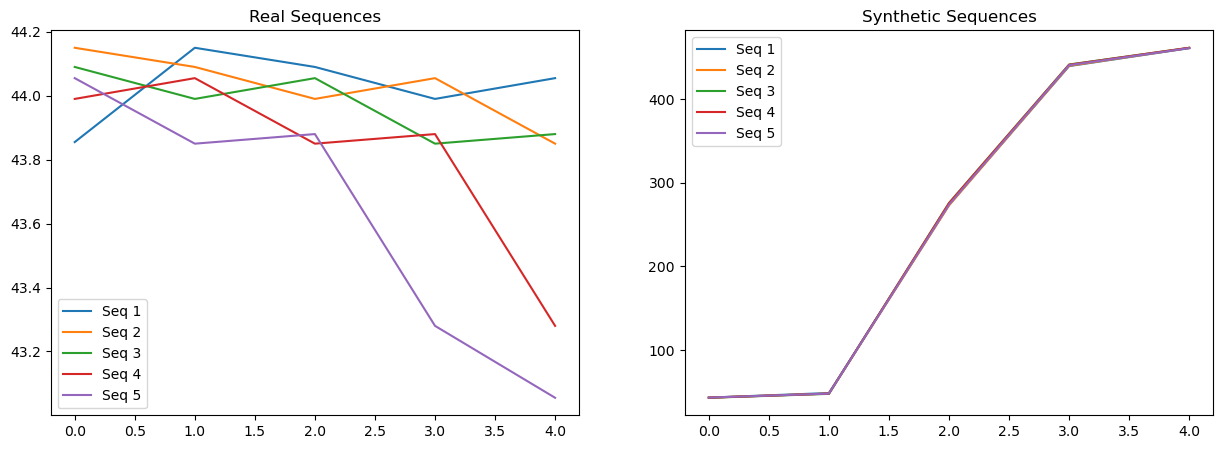

In [ ]:
# 1. Generate su X_train_norm
num_synthetic = int(X_train_norm.shape[0] * 0.5)  # 30% di dati sintetici
synthetic_sequences = timegan.generate_synthetic_data(num_synthetic, X_scaler,seq_len)

# 2. Usa il modello LSTM originale per generare i target
synthetic_targets = model.predict(synthetic_sequences)
#since our goal is forecasting, we also need to generate synthetic targets using the same LSTM model defined before

# 2. Visualizza il confronto tra sequenze reali e sintetiche
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)

for i in range(5):
    plt.plot(X_train_orig[i, :, 0], label=f'Seq {i+1}')
plt.title('Real Sequences')
plt.legend()

plt.subplot(1, 2, 2)
for i in range(5):
    plt.plot(synthetic_sequences[i, :, 0], label=f'Seq {i+1}')
plt.title('Synthetic Sequences')
plt.legend()
plt.show()



In [ ]:
# 3. Combine syntehtic and real
X_train_augmented = np.concatenate([X_train_norm, synthetic_sequences], axis=0)
y_train_augmented = np.concatenate([y_train_norm, synthetic_targets.flatten()], axis=0)

# 4. Shuffle the data
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

X_train_augmented
y_train_augmented


array([ 1.4332615 , -0.9207527 , -0.8196925 , ..., -0.26964214,
       -0.84969693,  1.4315817 ], dtype=float32)

In [ ]:
# 5. Train LSTM again with the augmented training dataset
model_augmented = Sequential([
    layers.Input((5, 1)),
    layers.LSTM(64),
    layers.Dense(32, activation='tanh'),
    layers.Dense(32, activation='tanh'),
    layers.Dense(1)
])

model_augmented.compile(
    loss=tf.keras.losses.Huber(delta=0.1),
    optimizer=Adam(learning_rate=0.0001),
    metrics=['mean_absolute_error']
)

# Addestra il modello con i dati aumentati
history_augmented = model_augmented.fit(
    X_train_augmented, 
    y_train_augmented,
    validation_data=(X_val_norm, y_val_norm),
    epochs=100
)

Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0388 - mean_absolute_error: 0.4326 - val_loss: 0.0276 - val_mean_absolute_error: 0.3264
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mean_absolute_error: 0.0550 - val_loss: 0.0034 - val_mean_absolute_error: 0.0736
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8224e-04 - mean_absolute_error: 0.0109 - val_loss: 0.0012 - val_mean_absolute_error: 0.0388
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3713e-04 - mean_absolute_error: 0.0090 - val_loss: 0.0013 - val_mean_absolute_error: 0.0405
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3284e-04 - mean_absolute_error: 0.0089 - val_loss: 0.0012 - val_mean_absolute_error: 0.0388
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2129e-04 - mean_absolute_error: 0.0086 - val_loss: 0.0013 - val_mean_absolute_error: 0.0404
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5907e-04 - mean_absolute_erro

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


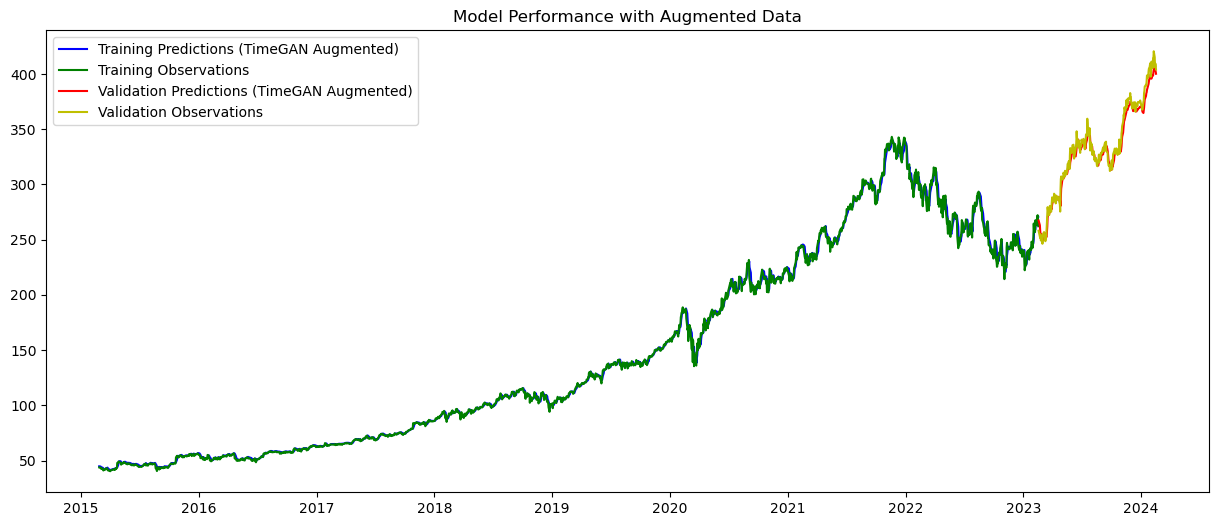

In [ ]:
# Check the performance of the LSTM model with AUGMENTED DATA
train_predictions_aug_norm = model_augmented.predict(X_train_norm)
val_predictions_aug_norm = model_augmented.predict(X_val_norm)


train_predictions__aug_orig = y_scaler.inverse_transform(train_predictions_aug_norm.reshape(-1, 1))
val__predictions__aug_orig = y_scaler.inverse_transform(val_predictions_aug_norm.reshape(-1, 1))

# Plot dei risultati
plt.figure(figsize=(15, 6))
plt.plot(dates_train, train_predictions__aug_orig, 'b', label='Training Predictions (TimeGAN Augmented)')
plt.plot(dates_train, y_train_orig, 'g', label='Training Observations')
plt.plot(dates_val, val__predictions__aug_orig, 'r', label='Validation Predictions (TimeGAN Augmented)')
plt.plot(dates_val, y_val_orig, 'y', label='Validation Observations')
plt.legend()
plt.title('Model Performance with Augmented Data')
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


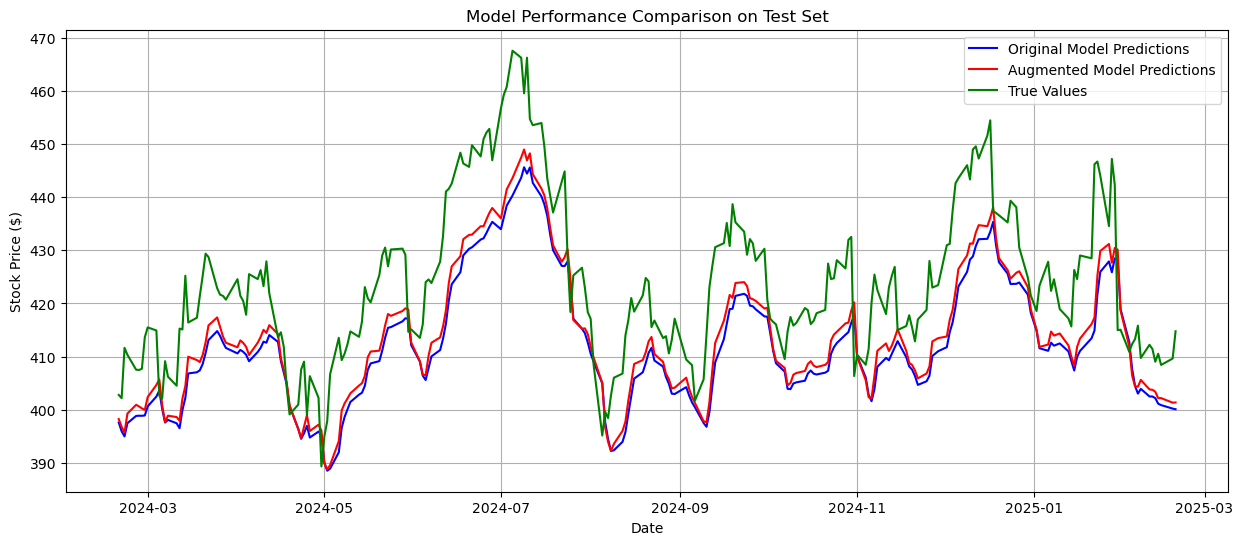

In [ ]:
# 1. Fai le predizioni sul test set usando entrambi i modelli
test_predictions_norm = model.predict(X_test_norm)  # modello originale
test_predictions_aug_norm = model_augmented.predict(X_test_norm) # modello con dati aumentati

test_predictions_orig = y_scaler.inverse_transform(test_predictions_norm.reshape(-1, 1))
test_predictions__aug_orig = y_scaler.inverse_transform(test_predictions_aug_norm.reshape(-1, 1))

# 2. Plot di confronto
plt.figure(figsize=(15, 6))
plt.plot(dates_test, test_predictions_orig, 'b', label='Original Model Predictions')
plt.plot(dates_test, test_predictions__aug_orig, 'r', label='Augmented Model Predictions')
plt.plot(dates_test, y_test_orig, 'g', label='True Values')
plt.title('Model Performance Comparison on Test Set')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Original model performance
mae_original = mean_absolute_error(y_test_orig, test_predictions_orig)
rmse_original = np.sqrt(mean_squared_error(y_test_orig, test_predictions_orig))

#Performance of model with augmented data
mae_augmented = mean_absolute_error(y_test_orig, test_predictions__aug_orig)
rmse_augmented = np.sqrt(mean_squared_error(y_test_orig, test_predictions__aug_orig))

print("\nTest Set Performance Metrics:")
print("\nOriginal Model:")
print(f"MAE: ${mae_original:.2f}")
print(f"RMSE: ${rmse_original:.2f}")

print("\nAugmented Model:")
print(f"MAE: ${mae_augmented:.2f}")
print(f"RMSE: ${rmse_augmented:.2f}")

#Improvement thanks to the synthetic data
mae_improvement = ((mae_original - mae_augmented) / mae_original) * 100
rmse_improvement = ((rmse_original - rmse_augmented) / rmse_original) * 100

print(f"\nImprovement with Data Augmentation:")
print(f"MAE Improvement: {mae_improvement:.2f}%")
print(f"RMSE Improvement: {rmse_improvement:.2f}%")


Test Set Performance Metrics:

Original Model:
MAE: $12.10
RMSE: $13.50

Augmented Model:
MAE: $10.55
RMSE: $11.85

Improvement with Data Augmentation:
MAE Improvement: 12.79%
RMSE Improvement: 12.21%
